# Assignment 3

Import required libraries

In [1]:
import torch
import random
import os
import numpy as np

In [2]:
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [3]:
# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load and Prepare Data

In [4]:
import pandas
from torch.utils.data import Dataset, DataLoader

from dataset import TransliterationDataset, collate_fn

In [5]:
def prepare_data(dataset_path, batch_size=64, shuffle=True):
    dataset = TransliterationDataset(dataset_path)
    data_loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        collate_fn=collate_fn
    )

    return dataset, data_loader

In [6]:
# Dataset paths
train_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.train.tsv'
val_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.dev.tsv'
test_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.test.tsv'

# Create dataloaders
train_dataset, train_loader = prepare_data(train_path, batch_size=64)
val_dataset, val_loader = prepare_data(val_path, batch_size=64)
test_dataset, test_loader = prepare_data(test_path, batch_size=64)

In [7]:
# Model parameters
input_size = train_dataset.get_vocab_size('source')
output_size = train_dataset.get_vocab_size('target')

# Print vocabulary sizes
print(f"Source vocabulary size: {input_size}")
print(f"Target vocabulary size: {output_size}")

Source vocabulary size: 30
Target vocabulary size: 74


In [8]:
# print(train_dataset.target_char_to_idx['<PAD>'])
# print(val_dataset.target_char_to_idx['<PAD>'])
# print(test_dataset.target_char_to_idx['<PAD>'])

## Train Model

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import trange

from attention_model import Encoder, AttentionDecoder, AttentionSeq2Seq
from training_attention import train, evaluate, transliterate, calculate_accuracy

In [15]:
def train_model(input_size, output_size, train_loader, val_loader, device, embedding_size=256, hidden_size=256, lr=0.001,
                n_layers=1, dropout=0.2, cell_type='lstm', epochs=10, teacher_forcing_ratio=0.5, clip=1.0, patience=5):  
    print(f"Using device: {device}")
    
    # Create model
    encoder = Encoder(
        input_size=input_size,
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        n_layers=n_layers,
        dropout=dropout,
        cell_type=cell_type
    ).to(device)
    
    decoder = AttentionDecoder(
        output_size=output_size,
        embedding_size=embedding_size,
        encoder_hidden_size=hidden_size,
        decoder_hidden_size=hidden_size,
        n_layers=n_layers,
        dropout=dropout,
        cell_type=cell_type
    ).to(device)
    
    model = AttentionSeq2Seq(encoder, decoder, device).to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # # Define learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.target_char_to_idx['<PAD>'])

    best_val_loss = float('inf')
    patience_counter = 0

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Training loop
    print("Starting training...")
    pbar = trange(epochs, desc="Epoch", dynamic_ncols=True)
    for epoch in pbar:
        # Train
        train_loss = train(
            model=model,
            device=device,
            dataloader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            clip=clip,
            teacher_forcing_ratio=teacher_forcing_ratio
        )
        train_losses.append(train_loss)
        
        # Validate
        val_loss = evaluate(
            model=model,
            device=device,
            dataloader=val_loader,
            criterion=criterion
        )
        val_losses.append(val_loss)

        # # Update learning rate based on validation loss
        # scheduler.step(val_loss)

        # Update tqdm bar description
        pbar.set_description(f"Epoch {epoch+1}/{epochs}")
        pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")
            
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved!")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs!")
            break
    
    return train_losses, val_losses

In [16]:
train_losses, val_losses = train_model(input_size=input_size, output_size=output_size, train_loader=train_loader, 
                                       val_loader=val_loader, device=device)

Using device: cuda
Starting training...


Epoch 1/10:  10%|█         | 1/10 [01:16<11:32, 76.90s/it, train_loss=1.0564, val_loss=8.7618]

Best model saved!


Epoch 6/10:  50%|█████     | 5/10 [07:41<07:41, 92.25s/it, train_loss=0.2492, val_loss=11.4832]

Early stopping after 6 epochs!


### Visualize training results

In [17]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and Validation Loss')

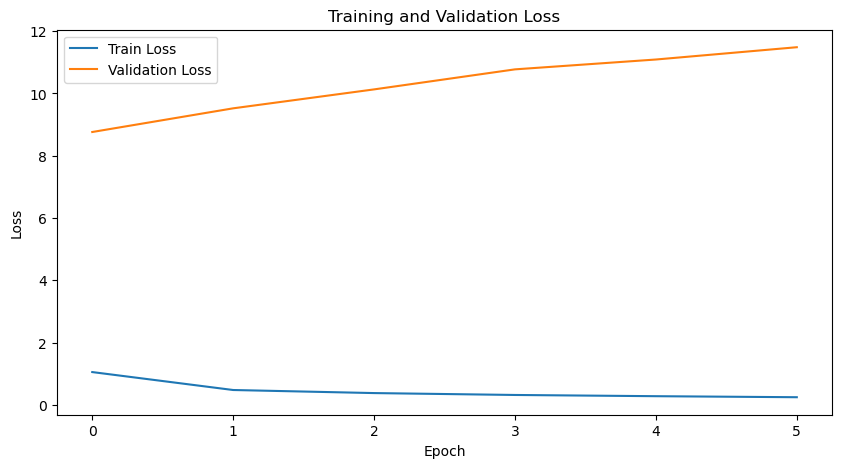

In [18]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
# plt.savefig('loss_plot.png')

## Hyperparameter Tuning with Wandb

In [19]:
import wandb

In [20]:
# Train model
BEST_VAL_LOSS = float('inf')

In [22]:
# Train the model with wandb integration
def train_with_wandb(config=None):
    global BEST_VAL_LOSS
    
    with wandb.init(config=config) as run:
        # If called by wandb.agent, use the config set by sweep controller
        config = wandb.config
        
        # Initialize a new wandb run
        # Generate a descriptive name for the run based on key hyperparameters
        run_name = f"ct{config.cell_type}-tfr{config.teacher_forcing_ratio}-lr{config.learning_rate}-es{config.embedding_size}-\
            hs{config.hidden_size}-nl{config.num_layers}-d{config.dropout}-bs{config.batch_size}"
        
        run.name = run_name
        run.save()
        # Initialize a new wandb run
        wandb.init()
        
        # Access hyperparameters as wandb.config
        config = wandb.config
        
        # Set seed
        set_seed(config.seed)
        
        # Device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Create save directory if it doesn't exist
        if not os.path.exists('models'):
            os.makedirs('models')
        
        # Dataset paths
        train_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.train.tsv'
        val_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.dev.tsv'

        # Create dataloaders
        train_dataset, train_loader = prepare_data(train_path, batch_size=64)
        _, val_loader = prepare_data(val_path, batch_size=64)
        
        # Create model
        encoder = Encoder(
            input_size=train_dataset.get_vocab_size('source'),
            embedding_size=config.embedding_size,
            hidden_size=config.hidden_size,
            n_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )
        
        decoder = AttentionDecoder(
            output_size=train_dataset.get_vocab_size('target'),
            embedding_size=config.embedding_size,
            encoder_hidden_size=config.hidden_size,
            decoder_hidden_size=config.hidden_size,
            n_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )
        
        model = AttentionSeq2Seq(encoder, decoder, device).to(device)
        print(f"Model created with cell type: {config.cell_type}")
        
        # Optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.target_char_to_idx['<PAD>'])
        
        # Train model
        best_val_loss = float('inf')

        pbar = trange(int(config.epochs), desc="Epoch", dynamic_ncols=True)
        for epoch in pbar:
            # Train
            train_loss = train(
                model, device, train_loader, optimizer, criterion, 
                clip=config.clip, teacher_forcing_ratio=config.teacher_forcing_ratio
            )
            
            # Evaluate
            val_loss = evaluate(model, device, val_loader, criterion=criterion)
            
            # Update tqdm bar description
            pbar.set_description(f"Epoch {epoch+1}/{config.epochs}")
            pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")

            # Log to wandb
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_loss
            })
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                model_path = os.path.join('models', f'model_{wandb.run.id}.pth')
                torch.save(model.state_dict(), model_path)

                if best_val_loss < BEST_VAL_LOSS:
                    BEST_VAL_LOSS = best_val_loss
                    torch.save(model.state_dict(), "best_model.pth")
                    print(f'\tBest model saved with val loss: {val_loss:.3f}')
        
        # Load best model for final evaluation
        model.load_state_dict(torch.load(os.path.join('models', f'model_{wandb.run.id}.pth')))
        
        # Evaluate accuracy on validation set
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                source_texts = batch['source_text']
                target_texts = batch['target_text']
                
                for i, source_text in enumerate(source_texts):
                    pred_text = transliterate(model, device, train_dataset, source_text)
                    
                    if pred_text == target_texts[i]:
                        correct += 1
                    total += 1
        
        val_accuracy = correct / total
        print(f'Validation Accuracy: {val_accuracy:.3f}')
        
        # Log final metrics
        wandb.log({
            'best_val_loss': best_val_loss,
            'val_accuracy': val_accuracy
        })

In [23]:
# Define sweep configuration
sweep_config = {
    'method': 'bayes',
    'name': 'sweep_attention',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'seed': {
            'values': [42]
        },
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'batch_size': {
            'values': [32, 64]
        },
        'embedding_size': {
            'values': [64, 128, 256]
        },
        'hidden_size': {
            'values': [128, 256]
        },
        'num_layers': {
            'values': [1, 2]
        },
        'dropout': {
            'values': [0.1, 0.3]
        },
        'cell_type': {
            'values': ['rnn', 'lstm', 'gru']
        },
        'teacher_forcing_ratio': {
            'values': [0.5, 0.7]
        },
        'clip': {
            'values': [1.0]
        },
        'epochs': {
            'values': [10]
        }
    }
}

In [25]:
os.environ["WANDB_NOTEBOOK_NAME"] = "attention_rnns.ipynb"

wandb.login()

True

In [26]:
sweep_id = wandb.sweep(sweep_config, project='DA6401-Assignment-3')

# Run the sweep
wandb.agent(sweep_id, train_with_wandb, count=15)

Create sweep with ID: 4v5h50a0
Sweep URL: https://wandb.ai/ch21b021-indian-institute-of-technology-madras/DA6401-Assignment-3/sweeps/4v5h50a0


wandb: Agent Starting Run: ou2l18eg with config:
wandb: 	batch_size: 32
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embedding_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Using device: cuda
Model created with cell type: lstm


Epoch 1/10:  10%|█         | 1/10 [01:27<13:09, 87.69s/it, train_loss=2.5791, val_loss=5.5420]

	Best model saved with val loss: 5.542


Epoch 10/10: 100%|██████████| 10/10 [14:16<00:00, 85.61s/it, train_loss=0.5400, val_loss=9.2199]


Validation Accuracy: 0.004


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁
val_loss,▁▂▃▄▅▅▆▇▇█
best_val_loss,5.54205
epoch,10
train_loss,0.54003
val_accuracy,0.00425
val_loss,9.21986


wandb: Agent Starting Run: oj2rvlni with config:
wandb: 	batch_size: 64
wandb: 	cell_type: rnn
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: rnn


Epoch 10/10: 100%|██████████| 10/10 [12:34<00:00, 75.42s/it, train_loss=0.5464, val_loss=9.3766]


Validation Accuracy: 0.032


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁
val_loss,▁▃▄▅▆▇▇▇██
best_val_loss,5.87237
epoch,10
train_loss,0.54637
val_accuracy,0.03173
val_loss,9.37656


wandb: Agent Starting Run: w00xltwl with config:
wandb: 	batch_size: 32
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embedding_size: 256
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 1/10:  10%|█         | 1/10 [01:22<12:20, 82.27s/it, train_loss=2.6293, val_loss=5.3755]

	Best model saved with val loss: 5.375


Epoch 10/10: 100%|██████████| 10/10 [13:49<00:00, 82.95s/it, train_loss=0.5457, val_loss=8.7317]


Validation Accuracy: 0.003


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁
val_loss,▁▂▃▄▅▅▆▇▇█
best_val_loss,5.37546
epoch,10
train_loss,0.54573
val_accuracy,0.00319
val_loss,8.7317


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3favgwjo with config:
wandb: 	batch_size: 64
wandb: 	cell_type: rnn
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 1
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: rnn


Epoch 10/10: 100%|██████████| 10/10 [11:24<00:00, 68.42s/it, train_loss=0.6212, val_loss=8.5479]


Validation Accuracy: 0.010


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁
val_loss,▁▃▄▅▆▆▇▇██
best_val_loss,5.4621
epoch,10
train_loss,0.62118
val_accuracy,0.00975
val_loss,8.54786


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j5j7dwia with config:
wandb: 	batch_size: 32
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 10/10: 100%|██████████| 10/10 [14:09<00:00, 84.92s/it, train_loss=0.1838, val_loss=12.9849]


Validation Accuracy: 0.328


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁
val_loss,▁▂▄▄▆▆▆▇██
best_val_loss,8.79354
epoch,10
train_loss,0.18382
val_accuracy,0.32796
val_loss,12.98489


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eqco8fcq with config:
wandb: 	batch_size: 32
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embedding_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 10/10: 100%|██████████| 10/10 [12:34<00:00, 75.43s/it, train_loss=0.2930, val_loss=11.1460]


Validation Accuracy: 0.233


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁
val_loss,▁▃▄▄▅▆▇▇██
best_val_loss,7.77483
epoch,10
train_loss,0.29298
val_accuracy,0.23311
val_loss,11.14596


wandb: Agent Starting Run: 6hda47wm with config:
wandb: 	batch_size: 64
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 1
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 1/10:  10%|█         | 1/10 [01:13<10:59, 73.27s/it, train_loss=2.9553, val_loss=5.0673]

	Best model saved with val loss: 5.067


Epoch 10/10: 100%|██████████| 10/10 [12:36<00:00, 75.67s/it, train_loss=0.9246, val_loss=7.7035]


Validation Accuracy: 0.000


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁
val_loss,▁▂▃▄▄▅▆▇▇█
best_val_loss,5.06732
epoch,10
train_loss,0.92459
val_accuracy,0.00035
val_loss,7.70349


wandb: Agent Starting Run: 9xiol9sn with config:
wandb: 	batch_size: 64
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 10/10: 100%|██████████| 10/10 [14:39<00:00, 87.92s/it, train_loss=0.8130, val_loss=8.6606]


Validation Accuracy: 0.002


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁
val_loss,▁▂▃▄▅▅▆▇▇█
best_val_loss,5.45523
epoch,10
train_loss,0.81299
val_accuracy,0.0016
val_loss,8.6606


wandb: Agent Starting Run: fni4hhfa with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 1
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: gru


Epoch 10/10: 100%|██████████| 10/10 [12:36<00:00, 75.70s/it, train_loss=0.7294, val_loss=8.3151]


Validation Accuracy: 0.001


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁
val_loss,▁▃▄▅▆▆▇▇██
best_val_loss,5.12335
epoch,10
train_loss,0.72942
val_accuracy,0.00142
val_loss,8.31514


wandb: Agent Starting Run: 5f6ker17 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 10/10: 100%|██████████| 10/10 [14:14<00:00, 85.49s/it, train_loss=1.0292, val_loss=7.5521]


Validation Accuracy: 0.001


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁
val_loss,▁▂▃▄▅▆▆▇▇█
best_val_loss,5.06834
epoch,10
train_loss,1.02922
val_accuracy,0.00053
val_loss,7.55205


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p1kqm39o with config:
wandb: 	batch_size: 64
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 1
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 10/10: 100%|██████████| 10/10 [12:21<00:00, 74.14s/it, train_loss=0.6886, val_loss=8.4932]


Validation Accuracy: 0.002


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▄▃▂▂▂▁▁
val_accuracy,▁
val_loss,▁▂▃▄▄▅▆▇▇█
best_val_loss,5.26215
epoch,10
train_loss,0.68857
val_accuracy,0.0023
val_loss,8.49321


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m9agp733 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 10/10: 100%|██████████| 10/10 [14:18<00:00, 85.80s/it, train_loss=0.8855, val_loss=8.0779]


Validation Accuracy: 0.001


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▄▃▂▂▂▁▁
val_accuracy,▁
val_loss,▁▂▃▄▅▅▆▇▇█
best_val_loss,5.2814
epoch,10
train_loss,0.8855
val_accuracy,0.00106
val_loss,8.07791


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qywzu2id with config:
wandb: 	batch_size: 64
wandb: 	cell_type: rnn
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: rnn


Epoch 10/10: 100%|██████████| 10/10 [12:53<00:00, 77.33s/it, train_loss=0.9178, val_loss=8.1049]


Validation Accuracy: 0.001


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁
val_loss,▁▂▃▄▅▆▇▇██
best_val_loss,5.13057
epoch,10
train_loss,0.91782
val_accuracy,0.00106
val_loss,8.10491


wandb: Agent Starting Run: nz58izyh with config:
wandb: 	batch_size: 64
wandb: 	cell_type: rnn
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 1
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: rnn


Epoch 10/10: 100%|██████████| 10/10 [11:47<00:00, 70.76s/it, train_loss=0.6505, val_loss=8.2772]


Validation Accuracy: 0.002


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁
val_loss,▁▃▄▅▆▆▇▇██
best_val_loss,5.30286
epoch,10
train_loss,0.6505
val_accuracy,0.0023
val_loss,8.27718


wandb: Agent Starting Run: 0bp8u4qu with config:
wandb: 	batch_size: 64
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 2
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda
Model created with cell type: lstm


Epoch 10/10: 100%|██████████| 10/10 [14:12<00:00, 85.29s/it, train_loss=1.0292, val_loss=7.5521]


Validation Accuracy: 0.001


best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁
val_loss,▁▂▃▄▅▆▆▇▇█
best_val_loss,5.06834
epoch,10
train_loss,1.02922
val_accuracy,0.00053
val_loss,7.55205


In [27]:
def analyze_errors(predictions):
    """
    Analyze the errors made by the model
    """
    # Count total predictions and correct predictions
    total = len(predictions)
    correct = sum(1 for _, pred, target in predictions if pred == target)
    
    print(f'Accuracy: {correct/total:.3f} ({correct}/{total})')
    
    # Analyze error patterns
    errors = [(source, pred, target) for source, pred, target in predictions if pred != target]
    
    # Error by length
    length_errors = {}
    for source, _, target in errors:
        length = len(source)
        if length not in length_errors:
            length_errors[length] = 0
        length_errors[length] += 1
    
    # Sort by length
    sorted_length_errors = {k: v for k, v in sorted(length_errors.items())}
    
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_length_errors.keys(), sorted_length_errors.values())
    plt.xlabel('Source Length')
    plt.ylabel('Number of Errors')
    plt.title('Errors by Source Length')
    plt.savefig('predictions_vanilla/errors_by_length.png')
    
    # Sample error analysis
    print("\nSample Error Analysis:")
    for i, (source, pred, target) in enumerate(errors[:10]):
        print(f'Source: {source}')
        print(f'Prediction: {pred}')
        print(f'Target: {target}')
        print()

In [ ]:
def test_best_model(best_config):
    # Load datasets
    train_dataset = TransliterationDataset('dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv')
    test_dataset = TransliterationDataset('dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv')
    
    # Make sure test dataset uses the same vocabulary as training
    test_dataset.source_char_to_idx = train_dataset.source_char_to_idx
    test_dataset.source_idx_to_char = train_dataset.source_idx_to_char
    test_dataset.target_char_to_idx = train_dataset.target_char_to_idx
    test_dataset.target_idx_to_char = train_dataset.target_idx_to_char
    
    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    # Initialize model with best configuration
    input_size = train_dataset.get_vocab_size('source')
    output_size = train_dataset.get_vocab_size('target')
    
    best_encoder = Encoder(
        input_size=input_size, 
        embedding_size=best_config['embedding_size'], 
        hidden_size=best_config['hidden_size'], 
        n_layers=best_config['encoder_layers'], 
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    best_decoder = Decoder(
        output_size=output_size, 
        embedding_size=best_config['embedding_size'], 
        hidden_size=best_config['hidden_size'], 
        n_layers=best_config['decoder_layers'], 
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    best_model = Seq2Seq(best_encoder, best_decoder, device).to(device)
    
    # Load model parameters
    best_model.load_state_dict(torch.load(f"model_{best_config['cell_type']}.pt"))
    
    # Evaluate on test set
    test_accuracy, test_predictions = calculate_accuracy(best_model, test_dataloader, train_dataset)
    
    print(f'Test Accuracy: {test_accuracy:.3f}')
    
    # Save predictions to file
    with open('predictions_vanilla/test_predictions.txt', 'w', encoding='utf-8') as f:
        for source, pred, target in test_predictions:
            f.write(f'Source: {source}\n')
            f.write(f'Prediction: {pred}\n')
            f.write(f'Target: {target}\n\n')
    
    # Create error analysis
    analyze_errors(test_predictions)
    
    return test_predictions

In [ ]:
# Make sure predictions directory exists
os.makedirs('predictions_vanilla', exist_ok=True)

In [ ]:
# Test best model
test_predictions = test_best_model(best_config)